In [45]:
import torch
import torchaudio
import torch.nn as nn
from pypinyin import lazy_pinyin
import matplotlib
import matplotlib.pyplot as plt
from dataclasses import dataclass
# import os
# from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
from pypinyin import Style, lazy_pinyin


initial_table = ['b', 'p', 'm', 'f',
                'd', 't', 'n', 'l',
                'g', 'k', 'h',
                'j', 'q', 'x',
                'zh', 'ch', 'sh', 'r', 'z', 'c', 's']

finals_table = [['i', 'u', 'v'], # 可以与下面的配成 iao, ue
                ['a', 'o', 'e', 
                'ai', 'ei', 'ao', 'ou', 
                'an', 'en', 'on', 'in', 'vn', 'un',
                'ang', 'eng', 'ong', 'ing', 'er']]

def get_labels():
    return ['-', '|'] + initial_table + finals_table[0] + finals_table[1]

def chinese2pinyin(text):
    initials = lazy_pinyin(text, strict=True, style=Style.INITIALS, errors=lambda x: u'')
    finals = lazy_pinyin(text, strict=True, style=Style.FINALS, errors=lambda x: u'')
    pinyin = []
    for i in range(len(finals)):
        # pinyin+=['|']
        if initials[i] != '':
            pinyin+=[initials[i]]
        if finals[i] != '':
            if len(finals[i])>1 and finals[i][0] in finals_table[0] and finals[i][1]!='n':
                pinyin+=[finals[i][0], finals[i][1:]]
            else: pinyin+=[finals[i]]
        if initials[i] == '' and finals[i] == '':
            pinyin+=['n']
    # if pinyin[-1] == '|':
    #     pinyin = pinyin[:-1]
    return pinyin[:]

','.join(chinese2pinyin('虐去无，恩，嗯好乌牛一呀忧元儿赢因翁'))

'n,v,e,q,v,u,en,n,h,ao,u,n,i,ou,i,i,a,i,ou,v,an,er,ing,in,u,eng'

In [3]:
from utils.chinese2pinyin2 import chinese2pinyin, get_labels

In [7]:
from utils.dataset import SpeechOceanDataset, STCMDSDataset
N_MELS = 80
def audio_transform(sample, sample_rate):
    audio = sample['audio']
    text = sample['text']
    mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,\
        n_fft=1024,power=1,hop_length=256,win_length=1024, n_mels=N_MELS, \
            f_min=0.0, f_max=8000.0, mel_scale="slaney", norm="slaney")
    # mel_transform = torchaudio.transforms.MelSpectrogram(
    #     sample_rate=16000,           ### 22050, 48000
    #     n_fft=1024,
    #     hop_length=256,
    #     n_mels=N_MELS                ### 64,    80
    # )
    # def chinese2pinyin(text):
    #     pinyin = lazy_pinyin(text, strict=True,errors=lambda x: u'')
    #     pinyin = [i for i in '|'.join(pinyin)]
    #     return pinyin
    # safe_log = lambda x: torch.log(x+2**(-15))
    return {'audio':mel_transform(audio),
            'text': chinese2pinyin(text)}

dataset = SpeechOceanDataset('../data/zhspeechocean/', transform=audio_transform)
# dataset = STCMDSDataset('./data/ST-CMDS-20170001_1-OS/', transform=audio_transform)

In [ ]:
# from model.quartznet import QuartzNet
# from model.config import quartznet5x5_config
# from utils.helper import get_labels

# model = QuartzNet(quartznet5x5_config, feat_in = 80, vocab_size=len(get_labels()))
# out, length = model(torch.zeros([2,80,581]), torch.tensor([581]))
# # model.encoder[0].net[0][0].stride[0]
# model.eval()
# out.shape, length

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
from model.quartz2 import QuartzNet
model = QuartzNet(n_mels=N_MELS, num_classes=len(get_labels()))
out, length = model(torch.zeros([2,80,581]), torch.tensor([581]))
# model
out.shape, length

(torch.Size([2, 28, 291]), tensor([291], dtype=torch.int32))

In [10]:
# model

In [11]:
from os.path import exists
def load_checkpoint(path):
    if exists(path):
        # save_log(f'e.txt', ['file',path,'exist, load checkpoint...'])
        checkpoint = torch.load(path, map_location=device)
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        initial_epoch = checkpoint['epoch']
        # loss = checkpoint['loss']
        # save_log(f'e.txt', ['initial_epoch:', initial_epoch, 'loss:', loss])
LOAD_PATH = './checkpoint/quartz/model-temp.pt'
# LOAD_PATH = './checkpoint/quartz/primewords-1.pt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_checkpoint(LOAD_PATH)
model.eval()
print('')

('hao|jiu|bu|jian|zhao|yi|tian|ju|ju|ba', torch.Size([1, 80, 169]))

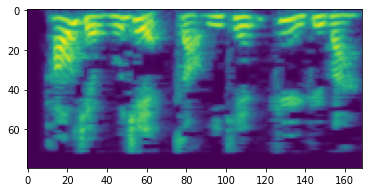

In [12]:
sample= dataset[5]
safe_log = lambda x: torch.log(x+2**(-15))
plt.imshow(safe_log(sample['audio'][0]))
''.join(sample['text']), sample['audio'].shape

('hao|ye|bu|yie|kao|yi|jin|ju||ba', torch.Size([85, 28]))

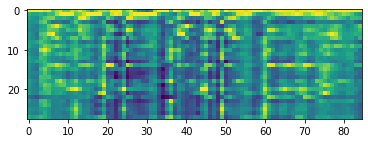

In [51]:
from utils.textDecoder import GreedyCTCDecoder, NaiveDecoder
# from utils.helper import get_labels
model.eval()
labels=get_labels()
decoder = GreedyCTCDecoder(labels)
out, _ = model(safe_log(sample['audio']))
emission = torch.log_softmax(out, dim=-2)[0]
emission = emission.T
plt.imshow(emission.T.detach().numpy(), interpolation='none')
transcript = sample['text']
''.join(decoder(emission)), emission.shape

In [52]:
dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))


def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    # Trellis has extra diemsions for both time axis and tokens.
    # The extra dim for tokens represents <SoS> (start-of-sentence)
    # The extra dim for time axis is for simplification of the code.
    trellis = torch.full((num_frame + 1, num_tokens + 1), -float("inf"))
    trellis[:, 0] = 0
    for t in range(num_frame):
        # print(emission[t, blank_id])
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens],
        )
    return trellis


trellis = get_trellis(emission, tokens).detach()

[('h', 10), ('a', 6), ('o', 4), ('|', 1), ('j', 25), ('i', 5), ('u', 14), ('|', 1), ('b', 21), ('u', 14), ('|', 1), ('j', 25), ('i', 5), ('a', 6), ('n', 7), ('|', 1), ('z', 27), ('h', 10), ('a', 6), ('o', 4), ('|', 1), ('y', 20), ('i', 5), ('|', 1), ('t', 3), ('i', 5), ('a', 6), ('n', 7), ('|', 1), ('j', 25), ('u', 14), ('|', 1), ('j', 25), ('u', 14), ('|', 1), ('b', 21), ('a', 6)]


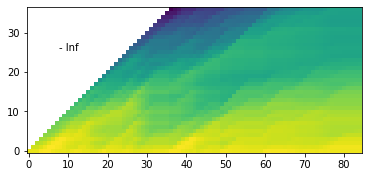

In [53]:
plt.imshow(trellis[1:, 1:].T, interpolation=None, origin="lower")
plt.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
# plt.colorbar()
plt.show()

In [54]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    # Note:
    # j and t are indices for trellis, which has extra dimensions
    # for time and tokens at the beginning.
    # When referring to time frame index `T` in trellis,
    # the corresponding index in emission is `T-1`.
    # Similarly, when referring to token index `J` in trellis,
    # the corresponding index in transcript is `J-1`.
    j = trellis.size(1) - 1
    t_start = torch.argmax(trellis[:, j]).item()

    path = []
    for t in range(t_start, 0, -1):
        # 1. Figure out if the current position was stay or change
        # Note (again):
        # `emission[J-1]` is the emission at time frame `J` of trellis dimension.
        # Score for token staying the same from time frame J-1 to T.
        stayed = trellis[t - 1, j] + emission[t - 1, blank_id]
        # Score for token changing from C-1 at T-1 to J at T.
        changed = trellis[t - 1, j - 1] + emission[t - 1, tokens[j - 1]]

        # 2. Store the path with frame-wise probability.
        prob = emission[t - 1, tokens[j - 1] if changed > stayed else 0].exp().item()
        # Return token index and time index in non-trellis coordinate.
        path.append(Point(j - 1, t - 1, prob))

        # 3. Update the token
        if changed > stayed:
            j -= 1
            if j == 0:
                break
    else:
        raise ValueError("Failed to align")
    return path[::-1]


path = backtrack(trellis, emission, tokens)
# print(path)

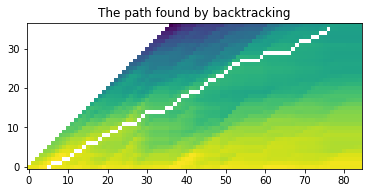

In [55]:
def plot_trellis_with_path(trellis, path):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path[1:, 1:].T, origin="lower")


plot_trellis_with_path(trellis, path)
plt.title("The path found by backtracking")
plt.show()

In [56]:
# Merge the labels
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

h	(0.53): [    4,     6)
a	(0.87): [    6,     7)
o	(0.27): [    7,    10)
|	(0.55): [   10,    12)
j	(0.10): [   12,    13)
i	(0.07): [   13,    15)
u	(0.02): [   15,    16)
|	(0.38): [   16,    19)
b	(0.49): [   19,    20)
u	(0.74): [   20,    22)
|	(0.64): [   22,    24)
j	(0.03): [   24,    25)
i	(0.21): [   25,    29)
a	(0.00): [   29,    30)
n	(0.00): [   30,    31)
|	(0.82): [   31,    36)
z	(0.52): [   36,    38)
h	(0.01): [   38,    39)
a	(0.97): [   39,    40)
o	(0.55): [   40,    42)
|	(0.37): [   42,    45)
y	(0.84): [   45,    46)
i	(0.73): [   46,    47)
|	(0.71): [   47,    49)
t	(0.55): [   49,    51)
i	(0.69): [   51,    52)
a	(0.01): [   52,    53)
n	(0.36): [   53,    55)
|	(0.88): [   55,    60)
j	(0.29): [   60,    61)
u	(0.67): [   61,    68)
|	(0.87): [   68,    69)
j	(0.00): [   69,    70)
u	(0.62): [   70,    73)
|	(0.54): [   73,    75)
b	(0.65): [   75,    77)
a	(0.68): [   77,    78)


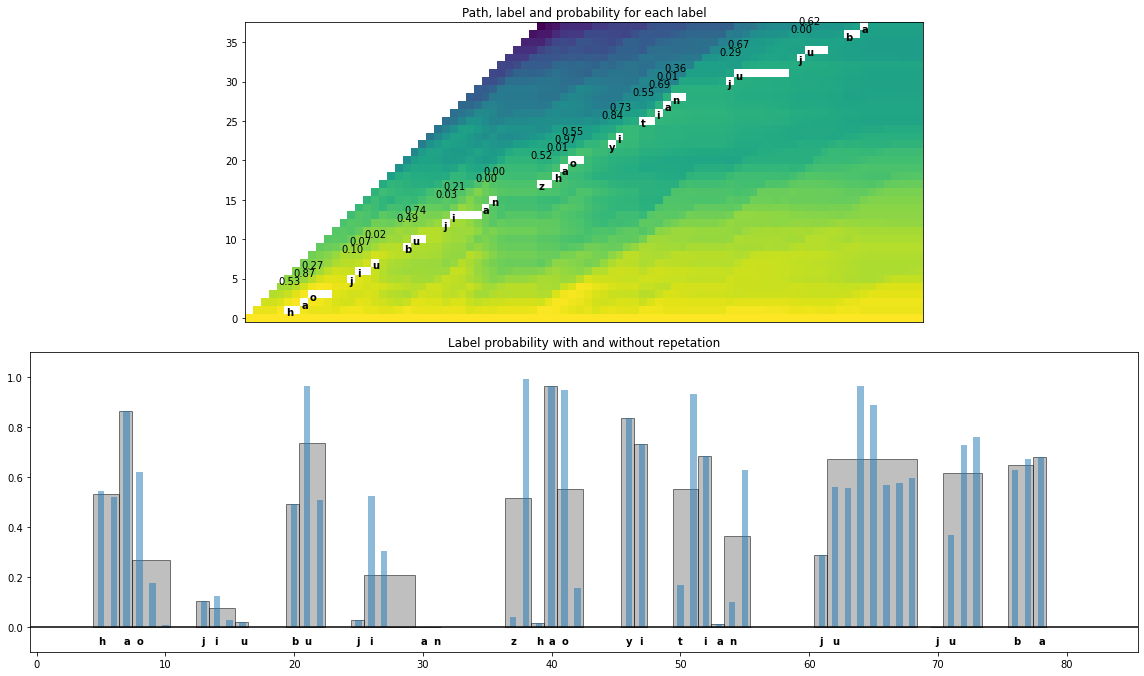

In [57]:
def plot_trellis_with_segments(trellis, segments, transcript):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    
    for i, seg in enumerate(segments):
        # if seg.label == '|':
        #     seg.label = ","
        if seg.label != "|":
            trellis_with_path[seg.start + 1 : seg.end + 1, i + 1] = float("nan")
        

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))
    ax1.set_title("Path, label and probability for each label")
    ax1.imshow(trellis_with_path.T, origin="lower")
    ax1.set_xticks([])

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start + 0.7, i + 0.3), weight="bold")
            ax1.annotate(f"{seg.score:.2f}", (seg.start - 0.3, i + 4.3))

    ax2.set_title("Label probability with and without repetation")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != "|":
            xs.append((seg.end + seg.start) / 2 + 0.4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + 0.8, -0.07), weight="bold")
    ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != "|":
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color="black")
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(-0.1, 1.1)
    


plot_trellis_with_segments(trellis, segments, transcript)
plt.tight_layout()
plt.show()

In [11]:
# model

In [12]:
decoder(out[0].T), out[0].T.shape

('ha||||||||||ha|||hia|||ha||||ha|||hua|||hi||||hi|||||a|||x-an||hi--||-a------------------------------------------------------------------',
 torch.Size([137, 28]))

In [47]:
from utils.dataset import SpeechDataset
class STCMDSDataset(SpeechDataset):

    def __init__(self, data_path, sample_rate=16000, transform=None):
        super().__init__(data_path, sample_rate, transform)
        files = os.listdir(data_path)
        file_names = []
        for file in files:
            if file.split('.')[1] == 'txt':
                file_names.append(file.split('.')[0])
        self.dataset_file_num = len(file_names)
        self.file_names = file_names
        self.threshold = 90000 # to avoid GPU memory used out
        self.batch_size = 128 # to avoid GPU memory used out
        self.split_ratio = [1000, 5]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        audio_name = self.get_audio(idx)
        waveform, sample_rate = torchaudio.load(audio_name)
        if sample_rate != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sample_rate, self.sample_rate)
        audio_content = self.get_text(idx)
        sample = {'audio': waveform, 'text': audio_content}
        if self.transform:
            sample = self.transform(sample, self.sample_rate)
        return sample

    def get_audio(self, x): 
        return self.data_path+self.file_names[x]+'.wav' if x < self.dataset_file_num else None
        
    def get_text(self, x): 
        return open(self.data_path+self.file_names[x]+'.txt', "r").read() if x < self.dataset_file_num else None

dataset = STCMDSDataset('./data/ST-CMDS-20170001_1-OS/', transform=audio_transform)

In [ ]:
plt.imshow(dataset[0]['audio'][0])
''.join(dataset[0]['text']), dataset[0]['audio'].shape

In [52]:
from utils.dataset import LoaderGenerator
from torch.utils.data import DataLoader, Dataset, random_split
from utils.helper import get_labels
loaderGenerator = LoaderGenerator(get_labels(), k_size=33)
train_set, test_set = dataset.split()
train_loader = loaderGenerator.dataloader(train_set, batch_size=8)
print('train_set:', len(train_set), 'test_set:',len(test_set))
steps = 10
for i_batch, sample_batched in enumerate(train_loader):
    print(sample_batched['audio'].shape, sample_batched['target'].shape)
    # plt.imshow(sample_batched['audio'][0])
    # print(loaderGenerator.id2label(sample_batched['target'][0].tolist()))
    # print(sample_batched['audio_len'][0])
    # print(sample_batched['target_len'][0])
    # break
    if steps < 0:
        break
    steps -= 1


train_set: 102089 test_set: 511
torch.Size([8, 80, 343]) torch.Size([8, 56])
torch.Size([8, 80, 323]) torch.Size([8, 59])
torch.Size([8, 80, 287]) torch.Size([8, 57])
torch.Size([7, 80, 351]) torch.Size([7, 63])
torch.Size([8, 80, 342]) torch.Size([8, 58])
torch.Size([7, 80, 342]) torch.Size([7, 46])
torch.Size([8, 80, 330]) torch.Size([8, 53])
torch.Size([8, 80, 299]) torch.Size([8, 54])
torch.Size([8, 80, 343]) torch.Size([8, 59])
torch.Size([8, 80, 336]) torch.Size([8, 45])
torch.Size([7, 80, 306]) torch.Size([7, 60])
torch.Size([8, 80, 331]) torch.Size([8, 59])


In [41]:
path = '/scratch/bh2283/data/data_aishell3/train/'
people_folder = path+'wav/'
wav_folders = [people_folder+i for i in os.listdir(people_folder)]
files = []
for wav_folder in wav_folders:
    files += [wav_folder+'/'+i for i in os.listdir(wav_folder)]
files[0]

'/scratch/bh2283/data/data_aishell3/train/wav/SSB0241/SSB02410469.wav'

In [56]:
from utils.dataset import SpeechDataset, random_split, RAWLoaderGenerator

class AiShell3Dataset(SpeechDataset):

    def __init__(self, data_path, sample_rate=16000, transform=None):
        super().__init__(data_path, sample_rate, transform)
        transcript_file = data_path+'content.txt'
        self.transcript = self.gen_transcript(transcript_file)
        self.wav_files = self.get_all_wav_files(data_path, self.transcript)
        self.dataset_file_num = len(self.wav_files)
        self.threshold = 120000 # to avoid GPU memory used out
        self.batch_size = 80 # to avoid GPU memory used out
        self.split_ratio = [1000, 5]

    def __len__(self):
        return self.dataset_file_num

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if idx >= self.dataset_file_num:
            return {'audio': None, 'text': None}
        audio_name = self.wav_files[idx]
        waveform, sample_rate = torchaudio.load(audio_name)
        if sample_rate != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sample_rate, self.sample_rate)
        dict_id = audio_name.rsplit('/',1)[-1].split('.')[0]
        audio_content = self.transcript[dict_id]
        sample = {'audio': waveform, 'text': audio_content}
        if self.transform:
            sample = self.transform(sample, self.sample_rate)
        return sample

    def parse_line(self, line):
        id, text = line.split('\t', 1)
        id = id.split('.')[0]
        # text = ''.join(text.split(' '))
        return id, text

    def gen_transcript(self, transcript_file):
        transcript = {}
        with open(transcript_file, 'r') as f:
            content = f.read()
            lines = content.split('\n')[:-1]
            for line in lines:
                id, text = self.parse_line(line)
                transcript[id] = text
        return transcript

    def get_all_wav_files(self, path, transcript):
        people_folder = path+'wav/'
        wav_folders = [people_folder+i for i in os.listdir(people_folder)]
        files = []
        for wav_folder in wav_folders:
            files += [wav_folder+'/'+i for i in os.listdir(wav_folder) if i[:-4] in transcript]
        return files
    
    def split(self, split_ratio=None, seed=42):
        audio_dataset = self
        size = len(audio_dataset)
        my_split_ratio = self.split_ratio if split_ratio is None else split_ratio
        lengths = [(i*size)//sum(my_split_ratio) for i in my_split_ratio]
        lengths[-1] = size - sum(lengths[:-1])
        split_dataset = random_split(audio_dataset, lengths, generator=torch.Generator().manual_seed(seed))
        return split_dataset

In [57]:
N_MELS = 80
def audio_transform(sample, sample_rate):
    audio = sample['audio']
    text = sample['text']
    mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,\
        n_fft=1024,power=1,hop_length=256,win_length=1024, n_mels=N_MELS, \
            f_min=0.0, f_max=8000.0, mel_scale="slaney", norm="slaney")
    return {'audio':audio,
            'text': chinese2pinyin(text)}
dataset = AiShell3Dataset('/scratch/bh2283/data/data_aishell3/train/', transform=audio_transform)

In [58]:
# dataset.transcript

In [60]:
from pypinyin import lazy_pinyin
from utils.helper import get_labels
labels = get_labels()
loaderGenerator = RAWLoaderGenerator(get_labels(), k_size=33)
train_set, test_set = dataset.split()
train_loader = loaderGenerator.dataloader(train_set, batch_size=8)
print('train_set:', len(train_set), 'test_set:',len(test_set))
steps = 10
for i_batch, sample_batched in enumerate(train_loader):
    print(sample_batched['audio'].shape, sample_batched['target'].shape, \
        sample_batched['audio_len'], sample_batched['target_len'])
    if steps < 0:
        break
    steps -= 1

train_set: 62947 test_set: 315
torch.Size([8, 72778]) torch.Size([8, 61]) tensor([60790, 72778, 36290, 35330, 66714, 71862, 49486, 52726]) tensor([43, 61, 29, 25, 56, 34, 37, 39])
torch.Size([8, 106300]) torch.Size([8, 77]) tensor([ 85887,  65399,  33960,  47972, 106300,  82818,  60740,  40103]) tensor([60, 44, 37, 52, 75, 77, 50, 49])
torch.Size([8, 102549]) torch.Size([8, 84]) tensor([ 66040,  62781,  58409,  76205,  52040, 102549,  62239,  61150]) tensor([55, 43, 42, 50, 46, 84, 39, 32])
torch.Size([7, 85415]) torch.Size([7, 67]) tensor([84047, 85415, 37132, 42758, 45056, 70646, 50985]) tensor([62, 67, 20, 40, 34, 50, 53])
torch.Size([8, 96562]) torch.Size([8, 89]) tensor([45400, 42464, 47538, 44617, 62074, 44857, 59351, 96562]) tensor([32, 31, 43, 34, 57, 23, 42, 89])
torch.Size([8, 82427]) torch.Size([8, 60]) tensor([82427, 64774, 70970, 51840, 51657, 35905, 73412, 44614]) tensor([60, 33, 38, 31, 42, 33, 34, 39])
torch.Size([8, 83448]) torch.Size([8, 70]) tensor([42774, 46059, 350

In [61]:
lens2 = [dataset[i+500]['audio'].shape[-1] for i in range(1000)]

In [62]:
lens = [dataset[i+1500]['audio'].shape[-1] for i in range(1000)]

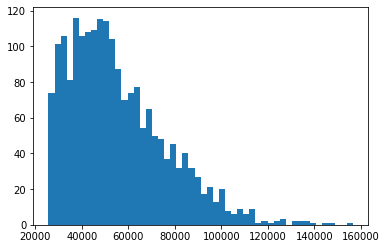

In [63]:
import matplotlib.pyplot as plt
plt.hist(lens+lens2, bins = 50)
plt.show()

In [20]:
import json

In [21]:
import os
from numpy import dtype
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchaudio

class PrimeWordsDataset(Dataset):

    def __init__(self, data_path, sample_rate=16000, transform=None):
        with open(data_path+'set1_transcript.json') as f:
            json_data = json.load(f)
        self.json_data = json_data
        # self.wav_files = self.get_all_wav_files(data_path, self.transcript)
        self.dataset_file_num = len(self.json_data)
        self.data_path = data_path
        self.transform = transform
        self.sample_rate = sample_rate
        self.threshold = 220000 # to avoid GPU memory used out
        self.batch_size = 40 # to avoid GPU memory used out
        self.split_ratio = [1000, 2]

    def __len__(self):
        return self.dataset_file_num

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if idx >= self.dataset_file_num:
            return {'audio': None, 'text': None}
        audio_file, audio_content = self.parse_line(self.json_data[idx])
        waveform, sample_rate = torchaudio.load(self.get_wav(audio_file))
        waveform = waveform
        if sample_rate != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sample_rate, self.sample_rate)
        sample = {'audio': waveform, 'text': audio_content}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def parse_line(self, line):
        return line['file'], line['text']

    def get_wav(self, file_name):
        path = self.data_path+'audio_files/'+file_name[0]+'/'+file_name[:2]+'/'+file_name
        return path

    def split(self, split_ratio=None, seed=42):
        audio_dataset = self
        size = len(audio_dataset)
        my_split_ratio = self.split_ratio if split_ratio is None else split_ratio
        lengths = [(i*size)//sum(my_split_ratio) for i in my_split_ratio]
        lengths[-1] = size - sum(lengths[:-1])
        split_dataset = random_split(audio_dataset, lengths, generator=torch.Generator().manual_seed(seed))
        return split_dataset

In [ ]:
dataset = PrimeWordsDataset('./data/primewords_md_2018_set1/')
lens = [dataset[i]['audio'].shape[-1] for i in range(500)]

In [ ]:
i=15
torchaudio.save('./audio-temp.wav', dataset[i]['audio'], 16000)
dataset[i]

{'audio': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0003, 0.0002, 0.0001]]),
 'text': '两碑尺寸相同 规格一致 均高六点八七米 分别由螭龙碑首'}

In [ ]:
lens2 = [dataset[i+500]['audio'].shape[-1] for i in range(1000)]

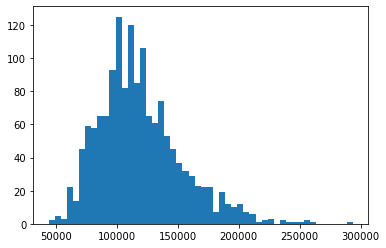

In [ ]:
import matplotlib.pyplot as plt
plt.hist(lens+lens2, bins = 50)
plt.show()

In [ ]:
import pandas as pd
data_path = './data/zhspeechocean/'


class SpeechOceanDataset(Dataset):
    def __init__(self, data_path, sample_rate=16000, transform=None):
        meta_data = data_path + 'metadata.csv'
        self.meta_data = pd.read_csv(meta_data, sep='\t')
        self.dataset_file_num = len(self.meta_data)
        self.data_path = data_path
        self.transform = transform
        self.sample_rate = sample_rate
        self.threshold = 90000 # to avoid GPU memory used out
        self.batch_size = 128 # to avoid GPU memory used out
        self.split_ratio = [100, 5]

    def __len__(self):
        return self.dataset_file_num

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if idx >= self.dataset_file_num:
            return {'audio': None, 'text': None}
        audio_name = os.path.join(self.data_path,
                                  self.meta_data.iloc[idx, 0])
        waveform, sample_rate = torchaudio.load(audio_name)
        audio_content = self.meta_data.iloc[idx, 1]
        if sample_rate != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sample_rate, self.sample_rate)
        sample = {'audio': waveform, 'text': audio_content}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def split(self, split_ratio=None, seed=42):
        audio_dataset = self
        size = len(audio_dataset)
        my_split_ratio = self.split_ratio if split_ratio is None else split_ratio
        lengths = [(i*size)//sum(my_split_ratio) for i in my_split_ratio]
        lengths[-1] = size - sum(lengths[:-1])
        split_dataset = random_split(audio_dataset, lengths, generator=torch.Generator().manual_seed(seed))
        return split_dataset

In [ ]:
if __name__ == '__main__':
    dataset = SpeechOceanDataset('./data/zhspeechocean/')
    batch_size = 8
    train_set, test_set = dataset.split([100, 5])
    k_size = 5 # kernel size for audio encoder
    from pypinyin import lazy_pinyin
    def chinese2pinyin(text):
        pinyin = lazy_pinyin(text, strict=True,errors=lambda x: u'')
        pinyin = [i for i in '|'.join(pinyin)]
        return pinyin
    from utils.helper import get_labels
    from utils.dataset import LoaderGenerator
    labels = get_labels()
    loaderGenerator = LoaderGenerator(labels, chinese2pinyin, k_size)
    train_loader = loaderGenerator.dataloader(train_set, batch_size)
    test_loader = loaderGenerator.dataloader(test_set, batch_size) # without backprop, can use larger batch
    print('train_set:', len(train_set), 'test_set:',len(test_set))
    steps = 10
    for i_batch, sample_batched in enumerate(test_loader):
        print(sample_batched['audio'].shape, sample_batched['target'].shape)
        # for i in sample_batched['audio']:
        #     print(i.shape)
        if steps < 0:
            break
        steps -= 1

train_set: 2285 test_set: 115
torch.Size([7, 76030]) torch.Size([7, 66])
torch.Size([8, 85818]) torch.Size([8, 66])
torch.Size([8, 80063]) torch.Size([8, 89])
torch.Size([7, 56436]) torch.Size([7, 54])
torch.Size([8, 76025]) torch.Size([8, 67])
torch.Size([8, 79484]) torch.Size([8, 68])
torch.Size([8, 65661]) torch.Size([8, 76])
torch.Size([8, 67958]) torch.Size([8, 75])
torch.Size([8, 59323]) torch.Size([8, 70])
torch.Size([8, 86392]) torch.Size([8, 66])
torch.Size([8, 55872]) torch.Size([8, 50])
torch.Size([8, 52413]) torch.Size([8, 47])


In [ ]:
dataset = SpeechOceanDataset('./data/zhspeechocean/')
lens = [dataset[i]['audio'].shape[-1] for i in range(2000)]

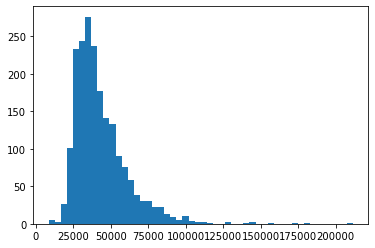

In [ ]:
import matplotlib.pyplot as plt
plt.hist(lens, bins = 50)
plt.show()

In [ ]:
i=15
torchaudio.save('./audio-temp.wav', dataset[i]['audio'], 16000)
dataset[i]

{'audio': tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -2.2709e-05,
          -7.3612e-05, -1.0139e-04]]),
 'text': '你这个周末有时间吗？你陪我去看看手机行吗？'}

In [ ]:
def chinese2pinyin(text):
    pinyin = lazy_pinyin(text, strict=True,errors=lambda x: u'')
    pinyin = [i for i in '|'.join(pinyin)]
    return pinyin
''.join(chinese2pinyin('你这个周末有时间吗？你陪我去看看手机行吗？'))

'ni|zhe|ge|zhou|mo|you|shi|jian|ma|ni|pei|wo|qu|kan|kan|shou|ji|xing|ma'

In [ ]:
class CvCorpus8Dataset(Dataset):

    def __init__(self, data_path, sample_rate=16000, transform=None):
        df1 = pd.read_csv(data_path+'validated.tsv',sep='\t')[['path', 'sentence']]
        # df2 = pd.read_csv(data_path+'invalidated.tsv',sep='\t')[['path', 'sentence']]
        # df3 = pd.read_csv(data_path+'other.tsv',sep='\t')[['path', 'sentence']]
        # df = pd.concat([df1, df2, df3])
        df = df1
        audio_path = df['path'].to_list()
        sentence_text = df['sentence'].to_list()
        assert len(audio_path) == len(sentence_text)
        self.audio_path = audio_path
        self.sentence_text = sentence_text
        self.size = len(audio_path)
        self.data_path = data_path
        self.transform = transform
        self.sample_rate = sample_rate
        self.threshold = 170000 # to avoid GPU memory used out
        self.batch_size = 64 # to avoid GPU memory used out
        self.split_ratio = [100, 1]

    def __len__(self):
        return len(self.audio_path)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        audio_name = self.get_audio(idx)
        waveform, sample_rate = torchaudio.load(audio_name)
        waveform = waveform
        if sample_rate != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sample_rate, self.sample_rate)
        audio_content = self.get_text(idx)
        sample = {'audio': waveform, 'text': audio_content}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def get_audio(self, x): 
        return self.data_path+'clips/'+self.audio_path[x] if x < len(self) else None
        
    def get_text(self, x): 
        return self.sentence_text[x] if x < len(self) else None
    
    def split(self, split_ratio=None, seed=42):
        audio_dataset = self
        size = len(audio_dataset)
        my_split_ratio = self.split_ratio if split_ratio is None else split_ratio
        lengths = [(i*size)//sum(my_split_ratio) for i in my_split_ratio]
        lengths[-1] = size - sum(lengths[:-1])
        split_dataset = random_split(audio_dataset, lengths, generator=torch.Generator().manual_seed(seed))
        return split_dataset

In [ ]:
if __name__ == '__main__':
    dataset = CvCorpus8Dataset('./data/cv-corpus-8.0-2022-01-19/zh-CN/')
    batch_size = 8
    train_set, test_set = dataset.split([100, 5])
    k_size = 5 # kernel size for audio encoder
    from pypinyin import lazy_pinyin
    def chinese2pinyin(text):
        pinyin = lazy_pinyin(text, strict=True,errors=lambda x: u'')
        pinyin = [i for i in '|'.join(pinyin)]
        return pinyin
    from utils.helper import get_labels
    from utils.dataset import LoaderGenerator
    labels = get_labels()
    loaderGenerator = LoaderGenerator(labels, chinese2pinyin, k_size)
    train_loader = loaderGenerator.dataloader(train_set, batch_size)
    test_loader = loaderGenerator.dataloader(test_set, batch_size) # without backprop, can use larger batch
    print('train_set:', len(train_set), 'test_set:',len(test_set))
    steps = 10
    for i_batch, sample_batched in enumerate(test_loader):
        print(sample_batched['audio'].shape, sample_batched['target'].shape)
        # for i in sample_batched['audio']:
        #     print(i.shape)
        if steps < 0:
            break
        steps -= 1

train_set: 44517 test_set: 2226
torch.Size([8, 124029]) torch.Size([8, 71])
torch.Size([8, 155901]) torch.Size([8, 126])
torch.Size([8, 148988]) torch.Size([8, 128])
torch.Size([8, 122877]) torch.Size([8, 110])
torch.Size([8, 142838]) torch.Size([8, 107])
torch.Size([8, 153984]) torch.Size([8, 131])
torch.Size([8, 142079]) torch.Size([8, 121])
torch.Size([8, 155904]) torch.Size([8, 90])
torch.Size([8, 131712]) torch.Size([8, 93])
torch.Size([8, 101753]) torch.Size([8, 94])
torch.Size([8, 97920]) torch.Size([8, 89])
torch.Size([8, 165877]) torch.Size([8, 140])


In [ ]:
dataset = CvCorpus8Dataset('./data/cv-corpus-8.0-2022-01-19/zh-CN/')

In [ ]:
i=18
torchaudio.save('./audio-temp.wav', dataset[i]['audio'], 16000)
dataset[i]

{'audio': tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0020, -0.0029, -0.0024]]),
 'text': '台湾北部地区家庭多以在农历年前时段包润饼则是在清明期间。'}

In [10]:
from utils.dataset import AiDataTangDataset

def raw_audio_transform(sample, sample_rate=None):
        audio = sample['audio']
        audio = audio / torch.abs(audio).max()*0.15
        sample['audio'] = audio
        sample['chinese'] = sample['text']
        return sample

dataset = AiDataTangDataset('/scratch/bh2283/data/aidatatang_200zh/', transform=raw_audio_transform)

In [16]:
dataset[0]

{'audio': tensor([[0.0007, 0.0007, 0.0006,  ..., 0.0005, 0.0005, 0.0005]]),
 'text': '这两天研究生考试',
 'chinese': '这两天研究生考试'}

In [13]:
lens = [dataset[i]['audio'].shape[-1] for i in range(2000)]

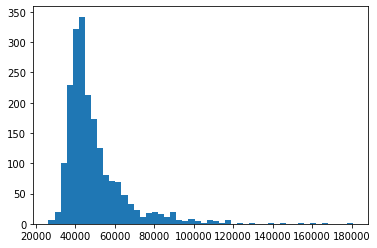

In [14]:
import matplotlib.pyplot as plt
plt.hist(lens, bins = 50)
plt.show()

In [21]:
def chinese2alphabet(chinese):
    pinyin = lazy_pinyin(chinese, strict=True,errors=lambda x: u'-')
    pinyin = [i for i in '|'.join(pinyin)]
    return pinyin

chinese2alphabet('HELLO?')

['-']

In [23]:
from string import ascii_uppercase, ascii_lowercase
ascii_uppercase, ascii_lowercase

('ABCDEFGHIJKLMNOPQRSTUVWXYZ', 'abcdefghijklmnopqrstuvwxyz')

In [9]:
import torch
from torchaudio.models.tacotron2 import _get_mask_from_lengths, _Decoder

In [10]:
_get_mask_from_lengths(torch.Tensor([1,2,4,5]))

tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False]])

In [15]:
input = torch.rand((1,2,3))
input

tensor([[[0.3865, 0.2079, 0.2112],
         [0.3973, 0.7489, 0.3942]]])

In [19]:
decoder = _Decoder()
decoder._parse_decoder_inputs(decoder, input)

TypeError: _Decoder.__init__() missing 14 required positional arguments: 'n_mels', 'n_frames_per_step', 'encoder_embedding_dim', 'decoder_rnn_dim', 'decoder_max_step', 'decoder_dropout', 'decoder_early_stopping', 'attention_rnn_dim', 'attention_hidden_dim', 'attention_location_n_filter', 'attention_location_kernel_size', 'attention_dropout', 'prenet_dim', and 'gate_threshold'